<a href="https://colab.research.google.com/github/ArashVafa/PDDA/blob/master/PDDA_Machine_Learning_Competition_2020_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>

* **Authors**: Marjan Sherafati, Arash Vafanejad
* **Date**: June 1st, 2020


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation.

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

In [0]:
# import libraries
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#df = pd.read_csv('/tmp/train.csv')

url = 'https://raw.githubusercontent.com/ArashVafa/PDDA/master/train.csv'

df = pd.read_csv(url)

In [0]:
url2 = 'https://raw.githubusercontent.com/ArashVafa/PDDA/master/test.csv'

dfTest = pd.read_csv(url2)

In [0]:
#hidden test set

url3 = 'https://raw.githubusercontent.com/ArashVafa/PDDA/master/real_result_20perc.csv'


In [0]:
dfTest.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
0,8.5781,0.3521,55.1824,0.8121,0.7810,6.8291,2.3256
1,8.5781,0.3639,57.0114,0.8038,0.7723,6.8100,2.3255
2,8.5781,0.3703,58.9263,0.7444,0.7048,6.7766,2.3212
3,8.5625,0.3667,57.3308,0.7169,0.6542,6.7219,2.3119
4,8.5781,0.3500,53.0624,0.6845,0.6109,6.6384,2.2982


In [0]:
df.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


In [0]:
df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


## <a>3. Exploratory Data Analysis</a>

In [0]:
# remove all rows that contains missing value
# removing all those datapoints greatly reduces the number of points we have for prediction
#we decided to replace the missing values with the mean of that column
df.replace(['-999', -999], np.nan, inplace=True)

#for i in df.columns[:-2]:
#  df[i].replace(np.nan, df[i].mean(), inplace=True)

In [0]:
df.dropna(axis=0, inplace=True)
df = df.reset_index(drop=True)
df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,8.426679,0.274416,49.889253,2.598719,5.835466,3.833792,2.410734,88.312221,182.051067
std,1.845912,3.062495,54.811017,3.465665,422.449589,4.375818,0.181713,23.542419,84.670122
min,5.930400,0.014500,1.038900,0.123600,0.134100,-0.023200,0.680600,49.970500,80.580400
25%,6.629100,0.120300,16.036800,0.810000,0.797300,0.049800,2.236100,70.423100,127.148800
50%,8.578100,0.187700,37.498000,1.814900,1.829300,3.287800,2.466500,79.695400,142.678500
75%,8.671900,0.329000,61.140700,3.337400,3.463300,7.061300,2.563700,102.482800,192.757800
max,21.064200,365.885000,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300,487.438400


In [0]:
import seaborn as sns

In [0]:
#sns.pairplot(df)

Let's see if there are any outliers that we need to take out

## <a>4. Preprocessing </a>

### <a>4.1. Outlier Detection</a>

In this section, we will explore finding the outlier values in predictor values and replacing them. More can be found in the following links:
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba



https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

We use Scipy stats to grab all values of columns that fall within 3 standard deviations from the mean, and ignore the rest as outliers

In [0]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df))

In [0]:
threshold = 3
print(np.where(z > threshold))

(array([    0,     0,     1, ..., 18264, 18265, 18266]), array([0, 5, 0, ..., 4, 2, 2]))


In [0]:
df2 = df[(z < 3).all(axis=1)].copy()
df2.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,19329.000000,19329.000000,19329.000000,19329.000000,19329.000000,19329.000000,19329.000000,19329.000000,19329.000000
mean,8.339734,0.231579,43.730003,2.433176,2.558751,3.626316,2.419941,87.022165,177.388806
std,1.726783,0.164797,34.597380,2.246535,5.652591,3.996015,0.173138,22.809885,79.527104
min,5.930400,0.026400,1.038900,0.129500,0.185300,-0.013100,1.887000,54.554900,96.900500
25%,6.606100,0.118800,15.379500,0.818100,0.803400,0.050200,2.242600,70.184500,126.726400
50%,8.578100,0.180900,36.699000,1.782100,1.798700,2.931500,2.477600,78.425900,140.886500
75%,8.656300,0.296600,59.974100,3.208000,3.352600,6.906900,2.565500,98.288500,188.117600
max,13.963400,4.241100,213.771500,12.989100,637.878300,16.944000,2.942800,155.980300,436.047700


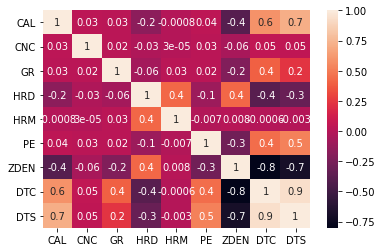

In [0]:
corrdf = df.corr()

sns.heatmap(corrdf, annot = True , fmt = '.1g')

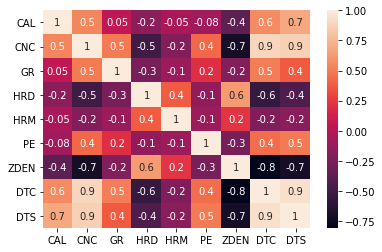

In [0]:
corrdf = df2.corr()

sns.heatmap(corrdf, annot = True , fmt = '.1g')

In [0]:
#how many data points are we deleting

df.shape[0] - df2.shape[0]

1196

In [0]:
#sns.pairplot(df2[['CAL', 'HRM', 'DTC', 'DTS']])

In [0]:
df2 = df2.reset_index(drop=True)
df2.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,13.6321,0.4633,58.7762,1.8688,1.4327,6.6753,2.1849,126.5374,305.9166
1,13.4571,0.4821,61.1278,1.7827,1.3871,6.6690,2.1394,127.0895,309.3540
2,13.4091,0.4821,62.9978,1.7049,1.3211,6.5535,2.1370,127.4648,312.7448
3,13.2954,0.4689,64.6493,1.6703,1.3012,6.6136,2.1395,127.6743,315.0485
4,13.2840,0.4865,65.5135,1.6453,1.2897,6.6984,2.1377,127.7576,316.3320


Maybe for HRM we might be able to get rid of more outliers!

Although z score less than 3 should be good, HRM still looks to have a lot of outliers. We are going to use df2

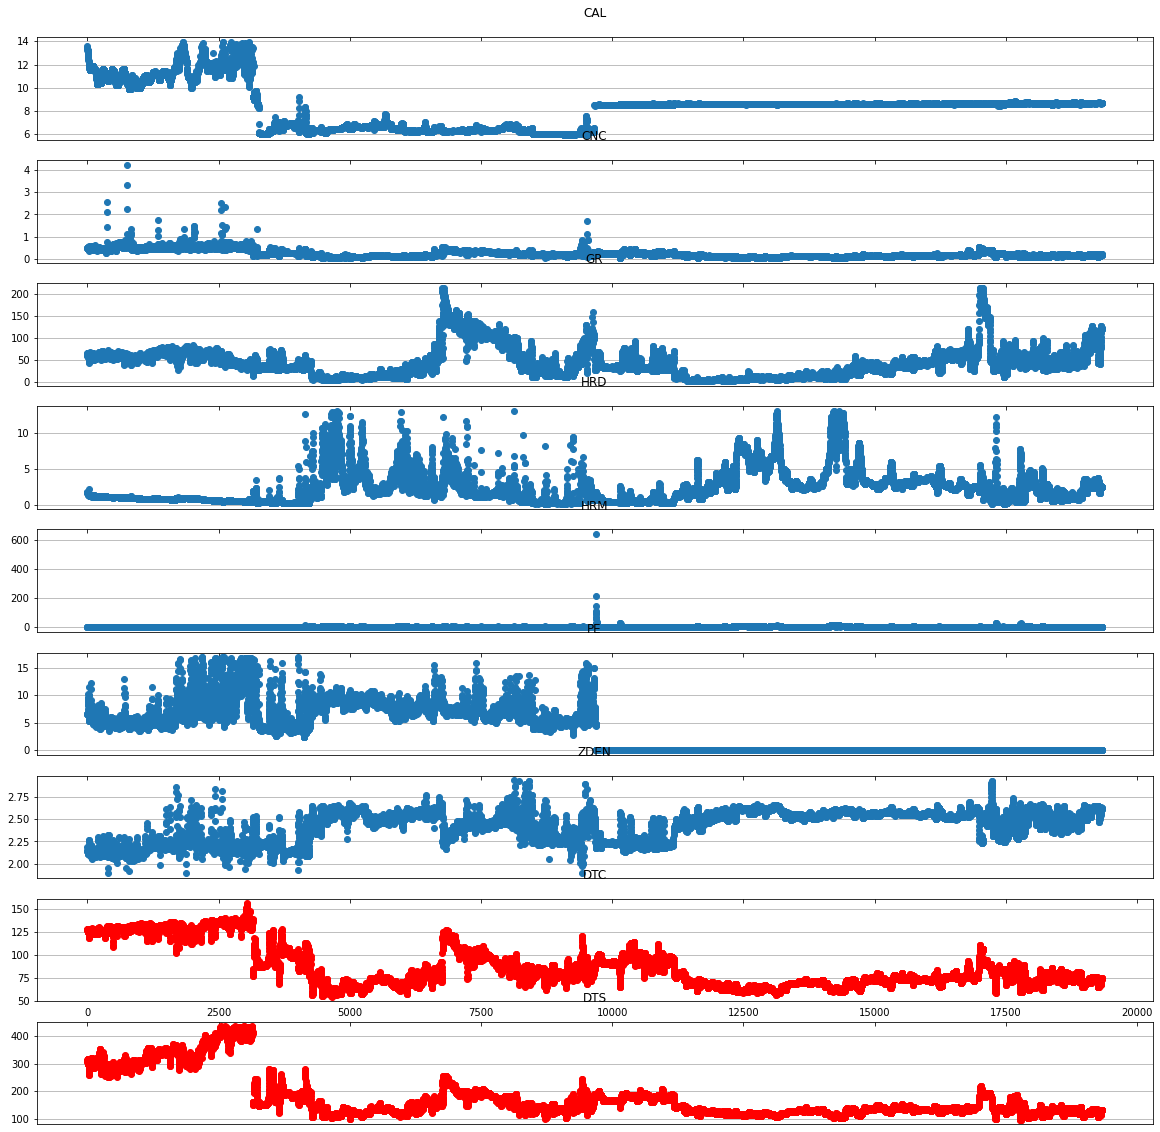

In [0]:

df_plot = df2.copy()

f, axarr = plt.subplots(9, 1, sharex=True, figsize=(20,20))

axarr[0].plot(df_plot["CAL"],'o')
axarr[0].set_title("CAL", pad=20)
axarr[0].xaxis.tick_top()
axarr[0].tick_params(axis="x",direction="in")
axarr[0].yaxis.grid()

axarr[1].plot(df_plot["CNC"],'o')
axarr[1].set_title("CNC",pad=20)
axarr[1].xaxis.tick_top()
axarr[1].tick_params(axis="x",direction="in")
axarr[1].yaxis.grid()

axarr[2].plot(df_plot["GR"],'o')
axarr[2].set_title("GR",pad=20)
axarr[2].xaxis.tick_top()
axarr[2].tick_params(axis="x",direction="in")
axarr[2].yaxis.grid()

axarr[3].plot(df_plot["HRD"],'o')
axarr[3].set_title("HRD",pad=20)
axarr[3].xaxis.tick_top()
axarr[3].tick_params(axis="x",direction="in")
axarr[3].yaxis.grid()

axarr[4].plot(df_plot["HRM"],'o')
axarr[4].set_title("HRM",pad=20)
axarr[4].xaxis.tick_top()
axarr[4].tick_params(axis="x",direction="in")
axarr[4].yaxis.grid()


axarr[5].plot(df_plot["PE"],'o')
axarr[5].set_title("PE",pad=20)
axarr[5].xaxis.tick_top()
axarr[5].tick_params(axis="x",direction="in")
axarr[5].yaxis.grid()

axarr[6].plot(df_plot["ZDEN"],'o')
axarr[6].set_title("ZDEN",pad=20)
axarr[6].xaxis.tick_top()
axarr[6].tick_params(axis="x",direction="in")
axarr[6].yaxis.grid()

axarr[7].plot(df_plot["DTC"],'ro')
axarr[7].set_title("DTC",pad=20)
axarr[7].xaxis.tick_top()
axarr[7].tick_params(axis="x",direction="in")
axarr[7].yaxis.grid()

axarr[8].plot(df_plot["DTS"],'ro')
axarr[8].set_title("DTS",pad=20)
axarr[8].xaxis.tick_top()
axarr[8].tick_params(axis="x",direction="in")
axarr[8].yaxis.grid()

### <a>4.2. Dataset Standardization and Splitting</a>


In [0]:
from sklearn.preprocessing import StandardScaler

# seperate the features and targets
df1_data = np.array(df2)
y_trainwell1 = df1_data[:,-2:]
x_trainwell1 = df1_data[:,:-2]

# standize the matrix for training data
scaler = StandardScaler().fit(x_trainwell1)
x_trainwell1 = scaler.transform(x_trainwell1)

In [0]:
dfTestH = pd.read_csv(url3)

# seperate the features and targets
df1_dataH = np.array(dfTestH)
y_TH = df1_dataH[:,-2:]
x_TH = df1_dataH[:,:-2]

# standize the matrix for training data
x_TH = scaler.transform(x_TH)

In [0]:
# seperate the features and targets
df1_data_test = np.array(dfTest)

x_testwell1 = df1_data_test

# standize the matrix for test data
#scaler = StandardScaler()
x_testwell1 = scaler.transform(x_testwell1)

In [0]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)

In [0]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', #'neg_root_mean_squared_error', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [0]:
def result_plot(y_predict, y_real=y_train):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True','Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

## <a>5. Model Construction</a>


### <a>5.1. Random Forest</a>

In [0]:
# Random forest model
RF = RandomForestRegressor(n_estimators=10, min_samples_split = 297, max_depth = 9, random_state=100)
RF_best = grid_search(RF, {})
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF_best.predict(X_train), y_train))))

RF_predict = RF_best.predict(x_TH)
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF_predict, y_TH))))

0.9727948475463485
Root Mean Square Error is: 7.94978
Root Mean Square Error is: 16.56793


In [0]:
def grid_search2(clf, param_grid, X_train=X_train, y_train=y_train, i = 0):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', #'neg_root_mean_squared_error', 
                        cv=5)
    grid.fit(X_train, y_train[:,i])
    print(grid.best_score_)
    
    return grid.best_estimator_

In [0]:
RF1 = RandomForestRegressor(n_estimators=10, min_samples_split = 297, max_depth = 9, random_state=100)
RF1_best = grid_search2(RF1, {}, i = 0)
print('estimator:', 'DTC')
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF1_best.predict(X_train), y_train[:,0]))))

RF1_predict = RF1_best.predict(x_TH)
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF1_predict, y_TH[:,0]))))


0.9697257876800005
estimator: DTC
Root Mean Square Error is: 3.74116
Root Mean Square Error is: 4.46758


In [0]:
RF2 = RandomForestRegressor(n_estimators=100, min_samples_split = 297, max_depth = 9, random_state=100)
RF2_best = grid_search2(RF2, {}, i = 1)
print('estimator:', 'DTS')
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF2_best.predict(X_train), y_train[:,1]))))

RF2_predict = RF2_best.predict(x_TH)
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF2_predict, y_TH[:,1]))))

df = np.column_stack([RF1_predict, RF2_predict])
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(df, y_TH))))

0.9789984061407984
estimator: DTS
Root Mean Square Error is: 10.56601
Root Mean Square Error is: 23.47693
Root Mean Square Error is: 16.89860


In [0]:
print(df.shape)

(2217, 2)


It seems that DTS error is independent of the parameters.

Root Mean Square Error is: 16.89860


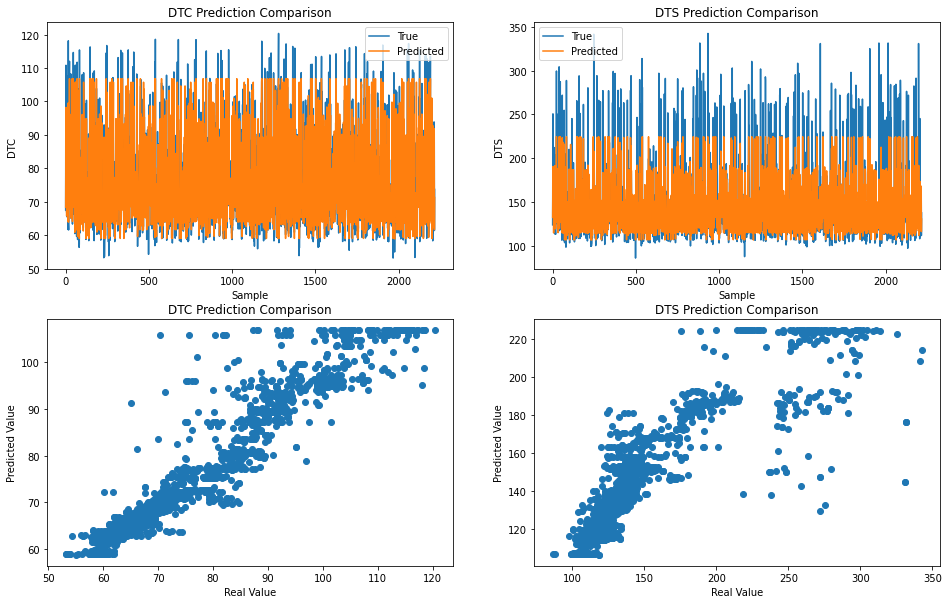

In [0]:
df = np.column_stack([RF1_predict, RF2_predict])
result_plot(df, y_TH)

Root Mean Square Error is: 16.56793


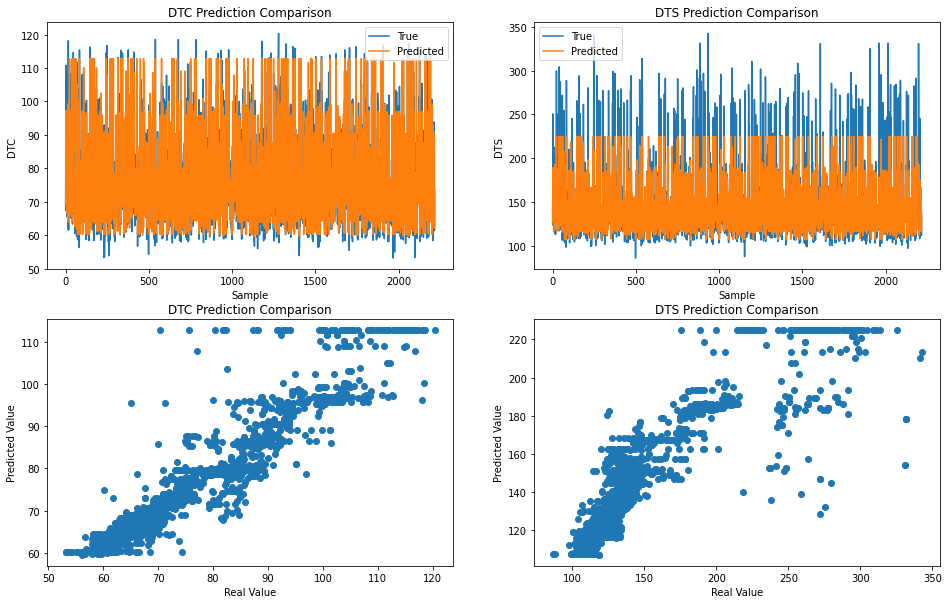

In [0]:
RF_predict = RF_best.predict(x_TH)
result_plot(RF_predict, y_TH)

In [0]:
'''for t in range(2,1000,50):
  RF2 = RandomForestRegressor(n_estimators=10, min_samples_split = t, max_depth = 9, random_state=100)
  RF2_best = grid_search2(RF2, {}, i = 1)
  print('estimator:', 'DTS')
  print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF2_best.predict(X_train), y_train[:,1]))))

  RF2_predict = RF2_best.predict(x_TH)
  print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF2_predict, y_TH[:,1]))))
'''

"for t in range(2,1000,50):\n  RF2 = RandomForestRegressor(n_estimators=10, min_samples_split = t, max_depth = 9, random_state=100)\n  RF2_best = grid_search2(RF2, {}, i = 1)\n  print('estimator:', 'DTS')\n  print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF2_best.predict(X_train), y_train[:,1]))))\n\n  RF2_predict = RF2_best.predict(x_TH)\n  print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(RF2_predict, y_TH[:,1]))))\n"

Root Mean Square Error is: 8.06185


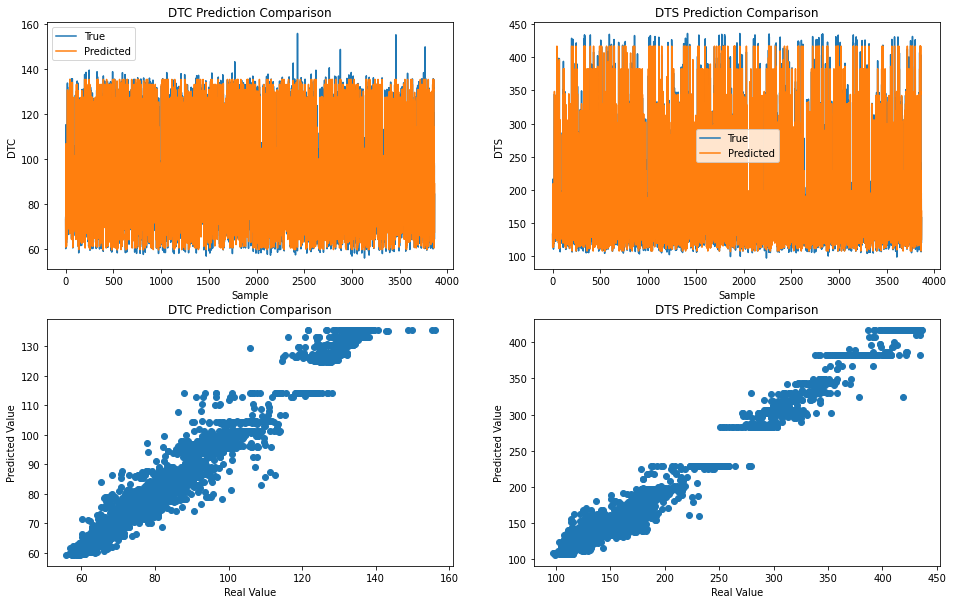

In [0]:
# check the result on test dataset only
result_plot(RF_best.predict(X_test), y_test)

Root Mean Square Error is: 7.97232


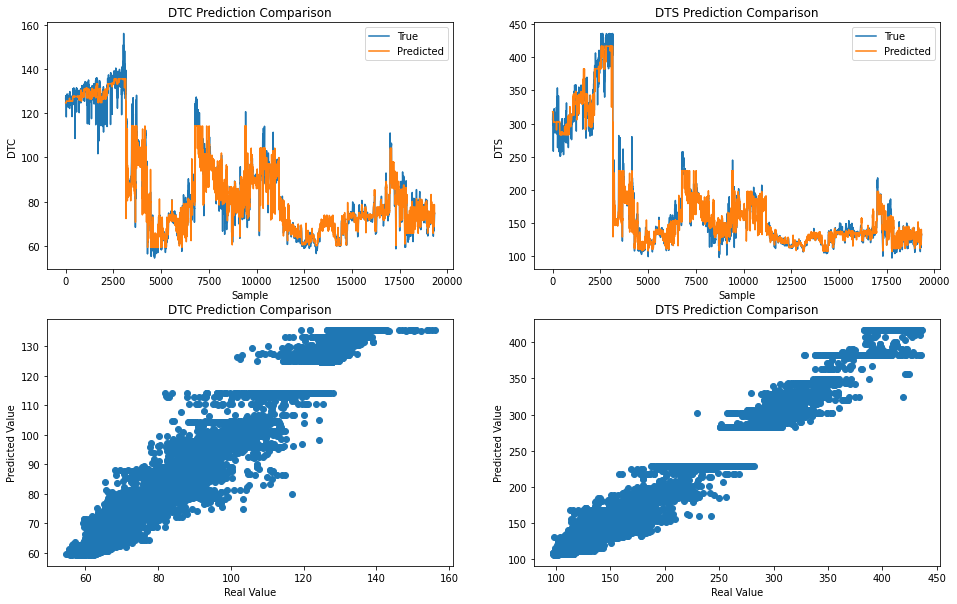

In [0]:
RF_predict = RF_best.predict(x_trainwell1)
result_plot(RF_predict, y_trainwell1)

### <a>5.2. Feed Forward Neural Networks</a>


https://towardsdatascience.com/feed-forward-neural-networks-c503faa46620

In [0]:
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [0]:
import tensorflow

In [0]:
df3 = df2.copy()

In [0]:

from numpy.random import seed
seed(1)


tensorflow.random.set_seed(2)



# Start neural network
network = models.Sequential()

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=8, activation='tanh', input_shape=(X_train.shape[1],)))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=10, activation='tanh'))

# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=10, activation='relu'))

# Add fully connected layer with no activation function
network.add(layers.Dense(units=1, activation= 'linear'))




# Compile neural network
network.compile(loss='mse', # Mean squared error
                optimizer='RMSprop', # Optimization algorithm #'RMSprop' --> 12.0394  'SGD' --> 12.2967 'Adam' --> 12.3337
                #'Adagrad' --> 175.4215 'Adadelta' --> 12.1322
                metrics=['mse']) # Mean squared error
network.summary()



# Train neural network
history = network.fit(X_train, # Features
                      y_train[:,0], # Target vector
                      epochs=50, # Number of epochs
                      verbose=0,
                      validation_data=(X_test, y_test[:,0])) # Data for evaluation

y_predictNN1 = network.predict(X_train)  
y_predictNNHT1 = network.predict(x_TH)   


'''
df = np.column_stack([y_predictNNHT1, y_predictNNHT2]) #y_predictNNHT1 RF2_predict
result_plot(df, y_TH)'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


'\ndf = np.column_stack([y_predictNNHT1, y_predictNNHT2]) #y_predictNNHT1 RF2_predict\nresult_plot(df, y_TH)'

Root Mean Square Error is: 16.91694


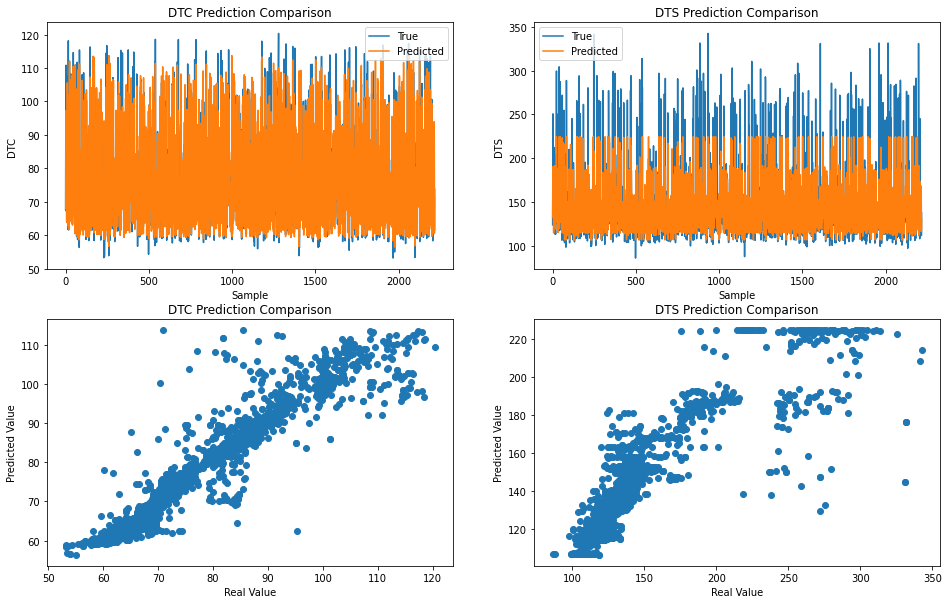

In [0]:
df = np.column_stack([y_predictNNHT1, RF2_predict]) #y_predictNNHT1
result_plot(df, y_TH)

In [0]:
df3 = df2.copy()

In [0]:
# Compile neural network
network.compile(loss='mse', # Mean squared error
                optimizer='RMSprop', # Optimization algorithm
                metrics=['mse']) # Mean squared error
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train neural network
history = network.fit(X_train, # Features
                      y_train[:,1], # Target vector
                      epochs=30, # Number of epochs
                      verbose=1, # No output
                      validation_data=(X_test, y_test[:,1])) # Data for evaluation

y_predictNN2= network.predict(X_train)
y_predictNNHT2 = network.predict(x_TH)  

Train on 15463 samples, validate on 3866 samples
Epoch 1/30
15463/15463 [==============================] - 1s 48us/step - loss: 6111.9008 - mse: 6111.9023 - val_loss: 4074.2974 - val_mse: 4074.2964
Epoch 2/30
15463/15463 [==============================] - 1s 42us/step - loss: 2126.8082 - mse: 2126.8086 - val_loss: 1270.8718 - val_mse: 1270.8721
Epoch 3/30
15463/15463 [==============================] - 1s 43us/step - loss: 642.8560 - mse: 642.8560 - val_loss: 518.4780 - val_mse: 518.4781
Epoch 4/30
15463/15463 [==============================] - 1s 41us/step - loss: 392.8597 - mse: 392.8597 - val_loss: 385.4480 - val_mse: 385.4480
Epoch 5/30
15463/15463 [==============================] - 1s 42us/step - loss: 307.7155 - mse: 307.7156 - val_loss: 312.6139 - val_mse: 312.6138
Epoch 6/30
15463/15463 [==============================] - 1s 41us/step - loss: 260.2328 - mse: 260.2328 - val_loss: 256.4418 - val_mse: 256.4418
Epoch 7/30
15463/15463 [==============================] - 1s 42us/step - 

Root Mean Square Error is: 19.78759


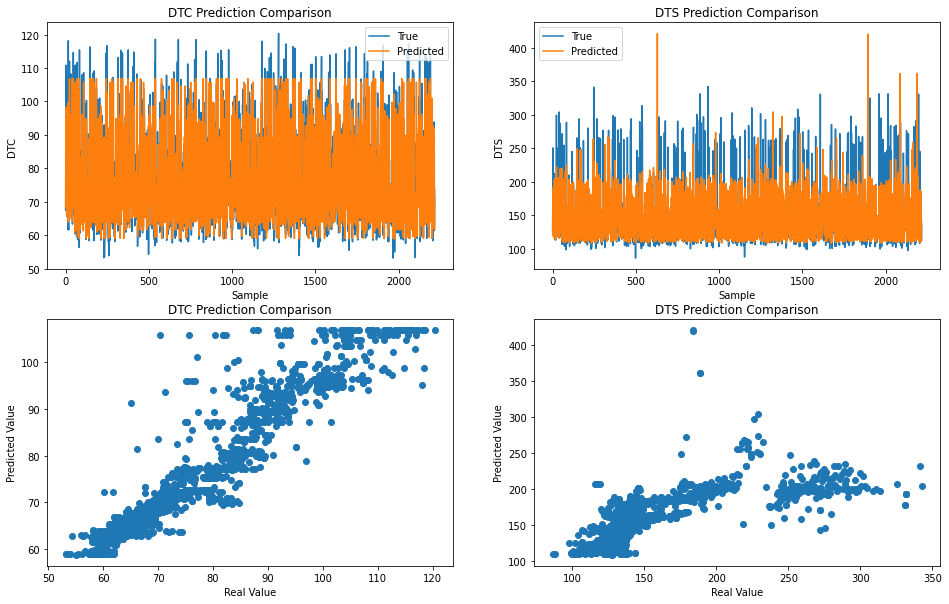

In [0]:
df = np.column_stack([RF1_predict, y_predictNNHT2])  #RF1_predict y_predictNNHT2
result_plot(df, y_TH)

In [0]:
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_predictNNHT2, y_TH[:,1]))))

Root Mean Square Error is: 27.62495


the neural network results are also not promising. In general, the second parameter (DTS) has much higher error in prediction than DTC. The driving cause for high RMSE's is DTS.

Root Mean Square Error is: 19.78759


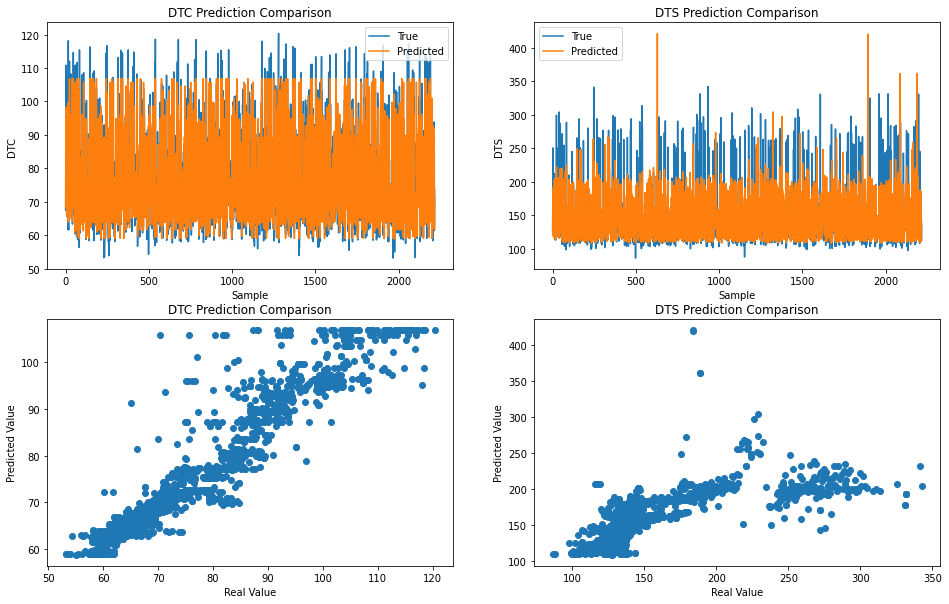

In [0]:
df = np.column_stack([RF1_predict, y_predictNNHT2])  #RF1_predict y_predictNNHT2
result_plot(df, y_TH)

## <a>6. Prediction</a>


In [0]:
url2 = 'https://raw.githubusercontent.com/ArashVafa/PDDA/master/test.csv'

In [0]:
# load test data from well 2
df2test = pd.read_csv('test2_19.csv')
# Remove missing 
for col in df2test.columns.tolist():
    df2test[col][df2test[col]==-999] = np.nan
df2test.dropna(axis=0, inplace=True)
df2_data = np.array(df2test)
x_trainwell2 = df2_data
x_trainwell2 = scaler.transform(x_trainwell2)
#print(y_trainwell2.head())
print(x_trainwell2[:5][:])

In [0]:
df2test.head()

In [0]:

y_predictNN2P= network.predict(x_trainwell2)

RF1_predictP = RF1_best.predict(x_trainwell2)

well2_predict = df = np.column_stack([RF1_predictP, y_predictNN2P]) 

In [0]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

In [0]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [0]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

In [0]:
output_result.nunique()

In [0]:
output_result.to_csv(path_or_buf='./LACrew_submission_2.csv', index=False)